# **Neural Network + Adam Optimisation**

## **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve)

## **Read Dataset**

In [2]:
# Load the dataset that has been preprocessed
data = pd.read_csv('dataset/preprocessed_breast-cancer.csv')

# Extract features (X) and target (y) from the dataset
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Neural Network Essentials**

### **Activation Functions**

In [3]:
def relu(Z):
    """Rectified Linear Unit activation function"""
    return np.maximum(0, Z)

def sigmoid(Z):
    """Sigmoid activation function for output layer"""
    return 1 / (1 + np.exp(-Z))

### **Derivative Functions**

In [4]:
def relu_derivative(Z):
    """Derivative of ReLU (1 when Z > 0, else 0)"""
    return Z > 0

def binary_crossentropy(y_true, y_pred):
    """Calculates binary cross-entropy loss"""
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

### **Configure Network Architecture**

### **Forward Propagation**

In [5]:
def forward_pass(X, W1, b1, W2, b2):
    """Calculate neural network outputs through forward propagation"""
    Z1 = np.dot(X, W1) + b1     # Linear combination for hidden layer
    A1 = relu(Z1)               # Activation for hidden layer
    Z2 = np.dot(A1, W2) + b2    # Linear combination for output layer
    A2 = sigmoid(Z2)            # Activation for output layer
    
    return Z1, A1, Z2, A2

### **Loss Calculation**

In [6]:
def compute_loss(y_true, y_pred):
    """Calculate binary cross-entropy loss with numerical stability"""
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

### **Backward Propagation**

In [7]:
def backward_pass(X, y, Z1, A1, Z2, A2, W2):
    """Computes gradients using chain rule"""
    batch_size = X.shape[0]
    
    # Output layer gradients
    dZ2 = A2 - y                                            # Derivative of loss w.r.t. Z2
    dW2 = np.dot(A1.T, dZ2) / batch_size                    # Gradient for W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size   # Gradient for b2
    
    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)                                 # Error propagated to hidden layer
    dZ1 = dA1 * (Z1 > 0)                                    # Gradient through ReLU
    dW1 = np.dot(X.T, dZ1) / batch_size                     # Gradient for W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size   # Gradient for b1
    
    return dW1, db1, dW2, db2

### **Adam Parameters Updater**

In [8]:
def update_parameters(params, grads, m_list, v_list, t):
    new_params = []
    new_m = []
    new_v = []

    beta1 = 0.9         # Exponential decay rate for 1st moment
    beta2 = 0.999       # Exponential decay rate for 2nd moment
    epsilon = 1e-8      # Numerical stability constant
    
    for param, grad, m, v in zip(params, grads, m_list, v_list):
        # Update first moment (mean)
        m = beta1 * m + (1 - beta1) * grad
        # Update second moment (uncentered variance)
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        # Bias correction estimates
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        # Parameter update
        param = param - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        new_params.append(param)
        new_m.append(m)
        new_v.append(v)
    
    return new_params, new_m, new_v

## **Model Building**

In [9]:
# Network architecture
input_layer = X_train.shape[1]
hidden_layer = 16

# Initialise parameters
np.random.seed(42)

# Create weight and bias for the hidden layer
W1 = np.random.randn(input_layer, hidden_layer) * 0.01
b1 = np.zeros((1, hidden_layer))

# Create weight and bias for the output layer
W2 = np.random.randn(hidden_layer, 1) * 0.01
b2 = np.zeros((1, 1))

In [10]:
# Define variables for Adam optimiser
m_W1, v_W1 = 0, 0
m_b1, v_b1 = 0, 0
m_W2, v_W2 = 0, 0
m_b2, v_b2 = 0, 0

## **Model Training**

In [11]:
# Define hyperparameters
epochs = 50
batch_size = 32
learning_rate = 0.001

In [12]:
# Scale the training data and apply it to testing data as well
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split the dataset again into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Track the training history for plotting
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [13]:
print(f"{'Epoch':^9} | {'Loss':^10} | {'Acc':^9} | {'Val Loss':^10} | {'Val Acc':^9}")
print("-" * 62)

for epoch in range(epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        # Batch selection
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
        
        # Compute metrics for loss and accuracy
        loss = compute_loss(y_batch, A2)
        predictions = (A2 > 0.5).astype(int)
        accuracy = np.mean(predictions == y_batch)
        epoch_loss.append(loss)
        epoch_acc.append(accuracy)
        
        # Backward pass
        dW1, db1, dW2, db2 = backward_pass(X_batch, y_batch, Z1, A1, Z2, A2, W2)
        
        # Parameter update with Adam
        params = [W1, b1, W2, b2]
        grads = [dW1, db1, dW2, db2]
        m_list = [m_W1, m_b1, m_W2, m_b2]
        v_list = [v_W1, v_b1, v_W2, v_b2]
        
        new_params, new_m, new_v = update_parameters(params, grads, m_list, v_list, epoch+1)
        
        # Update parameters and moments
        W1, b1, W2, b2 = new_params
        m_W1, m_b1, m_W2, m_b2 = new_m
        v_W1, v_b1, v_W2, v_b2 = new_v
    
    # Validation
    Z1_val, A1_val, Z2_val, A2_val = forward_pass(X_val, W1, b1, W2, b2)
    val_loss = compute_loss(y_val, A2_val)
    val_acc = np.mean((A2_val > 0.5).astype(int) == y_val)
    
    # Store metrics
    history['loss'].append(np.mean(epoch_loss))
    history['accuracy'].append(np.mean(epoch_acc))
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"{f'{epoch+1:3d}/{epochs:3d}':^9} | "
        f"{history['loss'][-1]:10.4f} | "
        f"{history['accuracy'][-1]:9.4f} | "
        f"{val_loss:10.4f} | "
        f"{val_acc:9.4f}")

  Epoch   |    Loss    |    Acc    |  Val Loss  |  Val Acc 
--------------------------------------------------------------
   1/ 50  |     0.6919 |    0.5981 |     0.6900 |    0.6044
   2/ 50  |     0.6872 |    0.6319 |     0.6848 |    0.6044
   3/ 50  |     0.6811 |    0.6424 |     0.6786 |    0.6264
   4/ 50  |     0.6744 |    0.6684 |     0.6721 |    0.6484
   5/ 50  |     0.6675 |    0.7023 |     0.6655 |    0.7253
   6/ 50  |     0.6607 |    0.7283 |     0.6589 |    0.7802
   7/ 50  |     0.6540 |    0.7413 |     0.6525 |    0.7912
   8/ 50  |     0.6474 |    0.7543 |     0.6462 |    0.8022
   9/ 50  |     0.6410 |    0.7674 |     0.6400 |    0.8022
  10/ 50  |     0.6347 |    0.7778 |     0.6339 |    0.8132
  11/ 50  |     0.6285 |    0.7778 |     0.6280 |    0.8242
  12/ 50  |     0.6224 |    0.7856 |     0.6221 |    0.8571
  13/ 50  |     0.6164 |    0.7960 |     0.6163 |    0.8571
  14/ 50  |     0.6105 |    0.8064 |     0.6105 |    0.8681
  15/ 50  |     0.6047 |    0.8186 | 

## **Model Evaluation**

In [14]:
# Forward pass on test set
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2

y_pred_probs = sigmoid(Z2_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

test_accuracy = np.mean(y_pred == y_test.ravel())
print(f"\nTest Accuracy: {test_accuracy:.4f}\n")


Test Accuracy: 0.9298



In [15]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        71
           1       1.00      0.81      0.90        43

    accuracy                           0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114



## **Visualisation**

### **Confusion Matrix**

<Figure size 800x600 with 0 Axes>

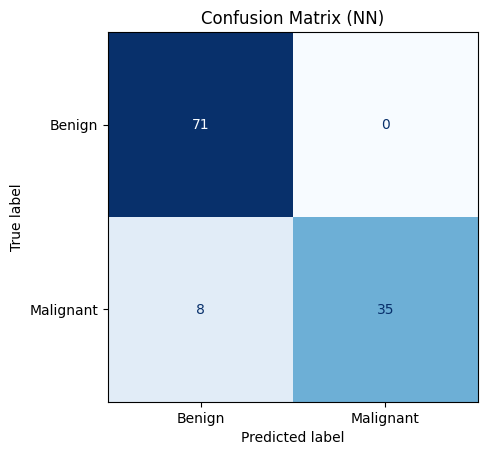

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

plt.figure(figsize=(8, 6))

disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)
plt.title("Confusion Matrix (NN)")

plt.show()

### **Accuracy of Training and Validation**

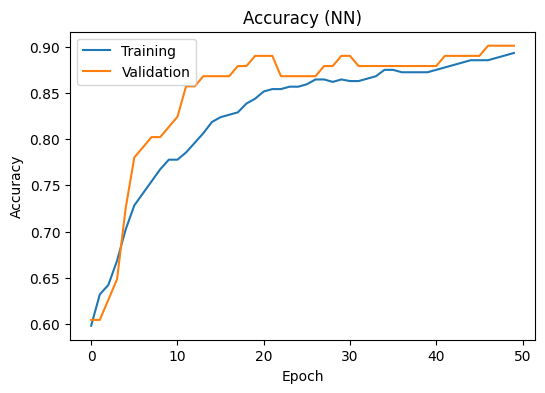

In [17]:
plt.figure(figsize=(6, 4))

plt.title('Accuracy (NN)')
plt.plot(history['accuracy'], label='Training')
plt.plot(history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

### **Loss of Training and Validation**

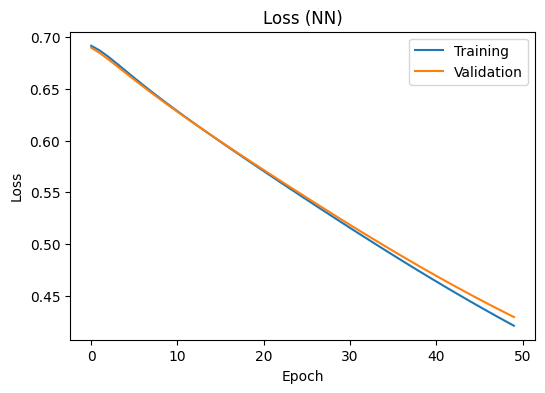

In [18]:
plt.figure(figsize=(6, 4))

plt.title('Loss (NN)')
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

### **Distribution of Predicted Probabilities**

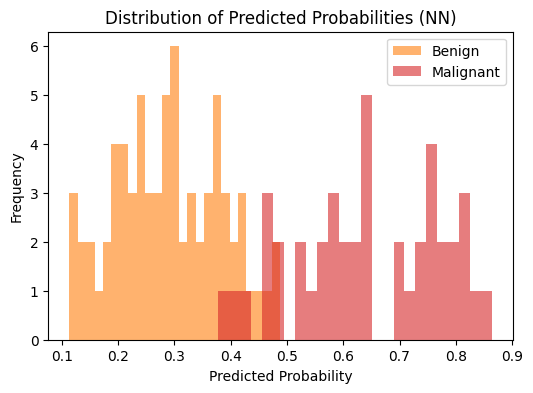

In [19]:
plt.figure(figsize=(6, 4))

plt.title('Distribution of Predicted Probabilities (NN)')
plt.hist(y_pred_probs[y_test.ravel() == 0], bins=25, alpha=0.6, color='tab:orange', label='Benign')
plt.hist(y_pred_probs[y_test.ravel() == 1], bins=25, alpha=0.6, color='tab:red', label='Malignant')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.legend()
plt.show()

### **Receiver Operating Characteristic (ROC) Curve**

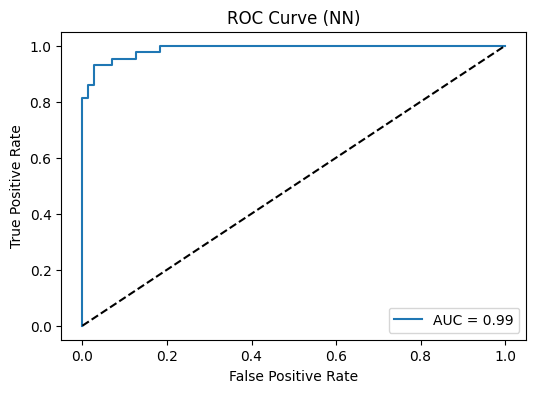

In [20]:
roc_auc = roc_auc_score(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(6, 4))

plt.title('ROC Curve (NN)')
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()